# Notebook for visualizing solutions

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from tqdm import tqdm
import sys
sys.path.append('..')
from src.models import PINN
from src.train_utils import *
from src.opts.adam_lbfgs_nncg import Adam_LBFGS_NNCG

## Training PINNs and saving models

### Convection (best)
`--seed 345 --pde convection --pde_params beta 40 --opt adam_lbfgs_nncg --opt_params adam_lr 0.0001 lbfgs_history_size 100 switch_epoch_lbfgs 11000 switch_epoch_nncg 12500 precond_update_freq 20 nncg_rank 60 nncg_mu 0.01 --num_layers 4 --num_neurons 200 --loss mse --num_x 257 --num_t 101 --num_res 10000 --epochs 14500`

### Reaction (best)
`--seed 456 --pde reaction --pde_params rho 5 --opt adam_lbfgs_nncg --opt_params adam_lr 0.001 lbfgs_history_size 100 switch_epoch_lbfgs 1000 switch_epoch_nncg 3000 precond_update_freq 20 nncg_rank 60 nncg_mu 0.01 --num_layers 4 --num_neurons 200 --loss mse --num_x 257 --num_t 101 --num_res 10000 --epochs 5000`

### Wave (best)
`--seed 234 --pde wave --pde_params beta 5 --opt adam_lbfgs_nncg --opt_params switch_epochs adam_lr 0.0001 lbfgs_history_size 100 switch_epoch_lbfgs 1000 switch_epoch_nncg 3000 precond_update_freq 20 nncg_rank 60 nncg_mu 0.1 --num_layers 4 --num_neurons 200 --loss mse --num_x 257 --num_t 101 --num_res 10000 --epochs 5000`

### Convection (high error)
`--seed 345 --pde convection --pde_params beta 40 --opt adam_lbfgs --opt_params switch_epochs 1000 adam_lr 0.0001 lbfgs_history_size 100 --num_layers 4 --num_neurons 400 --loss mse --num_x 257 --num_t 101 --num_res 10000 --epochs 3000`

### Reaction (high error)
`--seed 234 --pde reaction --pde_params rho 5 --opt adam_lbfgs --opt_params switch_epochs 31000 adam_lr 0.0001 lbfgs_history_size 100 --num_layers 4 --num_neurons 50 --loss mse --num_x 257 --num_t 101 --num_res 10000 --epochs 31500`

In [2]:
def train(initial_seed,
          pde_name,
          pde_params,
          opt_name,
          adam_lr,
          lbfgs_history_size,
          num_layers,
          num_neurons,
          loss_name,
          num_x,
          num_t,
          num_res,
          num_epochs,
          device,
          switch_epochs=None,
          switch_epoch_lbfgs=None,
          switch_epoch_nncg=None,
          precond_update_freq=None,
          nncg_rank=None,
          nncg_mu=None,
          filename_suffix=''):

    print("Starting: " + pde_name)

    # initialize model
    set_random_seed(initial_seed)

    model = PINN(in_dim=2, hidden_dim=num_neurons, out_dim=1, num_layer=num_layers).to(device)
    model.apply(init_weights)

    # get pde
    x_range, t_range, loss_func, pde_coefs = get_pde(pde_name, pde_params, loss_name)

    # initialize optimizer
    if opt_name == 'adam_lbfgs_nncg':
        opt_params_list = ["adam_lr",
                          str(adam_lr),
                          "lbfgs_history_size",
                          str(lbfgs_history_size),
                          "switch_epoch_lbfgs",
                          str(switch_epoch_lbfgs),
                          "switch_epoch_nncg",
                          str(switch_epoch_nncg),
                          "precond_update_freq",
                          str(precond_update_freq),
                          "nncg_rank",
                          str(nncg_rank),
                          "nncg_mu",
                          str(nncg_mu)]
    if opt_name == 'adam_lbfgs':
        opt_params_list = ["adam_lr",
                          str(adam_lr),
                          "lbfgs_history_size",
                          str(lbfgs_history_size),
                          "switch_epochs",
                          str(switch_epochs)]
    opt_params = get_opt_params(opt_params_list)
    opt = get_opt(opt_name, opt_params, model.parameters())

    # generate data
    x, t, data_params = get_data(x_range, t_range, num_x, num_t, random=True, num_res_samples=num_res, device=device)

    # obtain test data and referenced solution
    x_test, t_test, data_params_test = get_data(x_range, t_range, int((num_x - 1) / 2) + 1, num_t, random=False, device=device)
    targets = get_ref_solutions(pde_name, pde_coefs, x_test, t_test, data_params_test)

    # training
    for i in (progress_bar:=tqdm(range(num_epochs), ncols=125)):
        model.train()

        # update the preconditioner for NysNewtonCG
        if isinstance(opt, Adam_LBFGS_NNCG) and (i >= switch_epoch_nncg) and (i % precond_update_freq == 0):
            opt.zero_grad()
            outputs = predict(x, t, model)
            loss_res, loss_bc, loss_ic = loss_func(x, t, outputs)
            loss = loss_res + loss_bc + loss_ic
            grad_tuple = torch.autograd.grad(
                loss, model.parameters(), create_graph=True)
            opt.nncg.update_preconditioner(grad_tuple)

        # separate closure is needed for NysNewtonCG
        if isinstance(opt, Adam_LBFGS_NNCG) and (i >= switch_epoch_nncg):
            def closure():
                opt.zero_grad()
                outputs = predict(x, t, model)
                loss_res, loss_bc, loss_ic = loss_func(x, t, outputs)
                loss = loss_res + loss_bc + loss_ic
                grad_tuple = torch.autograd.grad(loss, model.parameters(), create_graph=True)
                return loss, grad_tuple
        else:
            def closure():
                opt.zero_grad()
                outputs = predict(x, t, model)
                loss_res, loss_bc, loss_ic = loss_func(x, t, outputs)
                loss = loss_res + loss_bc + loss_ic
                loss.backward()
                return loss

        opt.step(closure)

        # compute training loss and test errors at each switching epoch
        if (isinstance(opt, Adam_LBFGS_NNCG) and ((i == switch_epoch_lbfgs - 1) or (i == switch_epoch_nncg - 1) or (i == num_epochs - 1))) or (isinstance(opt, Adam_LBFGS) and (i == switch_epochs - 1)):
            model.eval()
            loss_res, loss_bc, loss_ic = loss_func(x, t, predict(x, t, model))
            loss = loss_res + loss_bc + loss_ic
            with torch.no_grad():
                predictions = torch.vstack(predict(x_test, t_test, model)).cpu().detach().numpy()
            test_l1re = l1_relative_error(predictions, targets)
            test_l2re = l2_relative_error(predictions, targets)
            print("loss {:.5e} / test l1rs {:.5e} / test l2rs {:.5e}".format(loss.item(), test_l1re, test_l2re))

        # save the model at each switching epoch
        if isinstance(opt, Adam_LBFGS_NNCG) and (i == switch_epoch_lbfgs - 1):
            torch.save({'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': opt.state_dict(),
                        'adam_state_dict': opt.adam.state_dict(),
                        'loss': loss.item(),
                        'l1re': test_l1re,
                        'l2re': test_l2re,
                       }, pde_name + '_adam' + filename_suffix)

        if isinstance(opt, Adam_LBFGS_NNCG) and (i == switch_epoch_nncg - 1):
            torch.save({'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': opt.state_dict(),
                        'lbfgs_state_dict': opt.lbfgs.state_dict(),
                        'loss': loss.item(),
                        'l1re': test_l1re,
                        'l2re': test_l2re,
                       }, pde_name + '_adam_lbfgs' + filename_suffix)

    # save the final model
    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'nncg_dict': opt.nncg.state_dict(),
                'loss': loss.item(),
                'l1re': test_l1re,
                'l2re': test_l2re,
               }, pde_name + '_' + opt_name + filename_suffix)

    # clean up
    del model
    torch.cuda.empty_cache()

In [3]:
device = "cuda"
run_specs = [
    {'initial_seed': 345,
    'pde_name': "convection",
    'pde_params': ["beta", "40"],
    'opt_name': "adam_lbfgs_nncg",
    'adam_lr': 0.0001,
    'lbfgs_history_size': 100,
    'switch_epoch_lbfgs': 11000,
    'switch_epoch_nncg': 12500,
    'precond_update_freq': 20,
    'nncg_rank': 60,
    'nncg_mu': 0.01,
    'num_layers': 4,
    'num_neurons': 200,
    'loss_name': "mse",
    'num_x': 257,
    'num_t': 101,
    'num_res': 10000,
    'num_epochs': 14500
    },
    {'initial_seed': 456,
    'pde_name': "reaction",
    'pde_params': ["rho", "5"],
    'opt_name': "adam_lbfgs_nncg",
    'adam_lr': 0.001,
    'lbfgs_history_size': 100,
    'switch_epoch_lbfgs': 1000,
    'switch_epoch_nncg': 3000,
    'precond_update_freq': 20,
    'nncg_rank': 60,
    'nncg_mu': 0.01,
    'num_layers': 4,
    'num_neurons': 200,
    'loss_name': "mse",
    'num_x': 257,
    'num_t': 101,
    'num_res': 10000,
    'num_epochs': 5000
    },
    {'initial_seed': 234,
    'pde_name': "wave",
    'pde_params': ["beta", "5"],
    'opt_name': "adam_lbfgs_nncg",
    'adam_lr': 0.0001,
    'lbfgs_history_size': 100,
    'switch_epoch_lbfgs': 1000,
    'switch_epoch_nncg': 3000,
    'precond_update_freq': 20,
    'nncg_rank': 60,
    'nncg_mu': 0.1,
    'num_layers': 4,
    'num_neurons': 200,
    'loss_name': "mse",
    'num_x': 257,
    'num_t': 101,
    'num_res': 10000,
    'num_epochs': 5000
    },
    {'initial_seed': 345,
    'pde_name': "convection",
    'pde_params': ["beta", "40"],
    'opt_name': "adam_lbfgs",
    'adam_lr': 0.0001,
    'lbfgs_history_size': 100,
    'switch_epochs': 1000,
    'num_layers': 4,
    'num_neurons': 400,
    'loss_name': "mse",
    'num_x': 257,
    'num_t': 101,
    'num_res': 10000,
    'num_epochs': 3000,
    'filename_suffix': '_high_error',
    },
    {'initial_seed': 234,
    'pde_name': "reaction",
    'pde_params': ["rho", "5"],
    'opt_name': "adam_lbfgs",
    'adam_lr': 0.0001,
    'lbfgs_history_size': 100,
    'switch_epochs': 31000,
    'num_layers': 4,
    'num_neurons': 50,
    'loss_name': "mse",
    'num_x': 257,
    'num_t': 101,
    'num_res': 10000,
    'num_epochs': 31500,
    'filename_suffix': '_high_error',
    }
]

In [ ]:
for spec in run_specs:
    train(device=device, **spec)

## Visualizing solutions

In [5]:
def get_title(pde_name, pde_params):
    if pde_name == "convection":
        return f'Convection, $\\beta = {pde_params[1]}$'
    elif pde_name == "reaction":
        return f'Reaction, $\\rho = {pde_params[1]}$'
    elif pde_name == "wave":
        return f'Wave, $\\beta = {pde_params[1]}$'

def reshape_solution(u, num_x, num_t):
    u_res = u[ : (num_t-1)*(num_x-2)].reshape(num_t-1, num_x-2)
    u_left = u[(num_t-1)*(num_x-2) : (num_t-1)*(num_x-2)+num_x].flatten()
    u_upper = u[(num_t-1)*(num_x-2)+num_x : (num_t-1)*(num_x-2)+num_x+num_t].flatten()
    x_lower = u[(num_t-1)*(num_x-2)+num_x+num_t : ].flatten()

    u_grid = np.zeros([num_t, num_x])
    u_grid[1:, 1:-1] = u_res
    u_grid[0,:] = u_left
    u_grid[:,0] = x_lower
    u_grid[:,-1] = u_upper

    # change indexing from 'xy' to 'ij'
    u_grid = u_grid.T # np.swapaxes(np.flip(u_grid, 1), 0, 1)

    return u_grid

def get_pinn_solution(spec, x, t, checkpoint_name, device):
    model = PINN(in_dim=2, hidden_dim=spec['num_neurons'], out_dim=1, num_layer=spec['num_layers']).to(device)
    model.load_state_dict(torch.load(checkpoint_name, map_location=device)['model_state_dict'])
    model.eval()
    with torch.no_grad():
        predictions = torch.vstack(predict(x, t, model)).cpu().detach().numpy()
    del model
    torch.cuda.empty_cache()
    return predictions

def make_diff_plot(fig, ax, u_diff, num_x, num_t, x_range, t_range, title, vmax):
    pos = ax.imshow(reshape_solution(u_diff, num_x, num_t),
                    extent=np.concatenate([t_range, x_range]),
                    cmap='plasma',
                    aspect='auto',
                    origin='lower',
                    vmin=0.0,
                    vmax=vmax)
    fig.colorbar(pos, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("$t$")
    ax.set_ylabel("$x$")

def make_solution_plot(fig, ax, u, num_x, num_t, x_range, t_range, title, vmin, vmax):
    pos = ax.imshow(reshape_solution(u, num_x, num_t),
                    extent=np.concatenate([t_range, x_range]),
                    cmap='viridis',
                    aspect='auto',
                    origin='lower',
                    vmin=vmin,
                    vmax=vmax)
    fig.colorbar(pos, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("$t$")
    ax.set_ylabel("$x$")

def plot_solution_errors(specs,
                         num_samples_x,
                         num_samples_t,
                         device,
                         font_size,
                         folder_path,
                         filename):

    mpl.rcParams.update({'font.size': font_size})
    nrows = len(specs)
    ncols = 3

    fig = plt.figure(constrained_layout=True, figsize=(ncols * 5, nrows * 4))
    subfigs = fig.subfigures(nrows=nrows, ncols=1)

    for row, subfig in enumerate(subfigs):
        spec = specs[row]
        subfig.suptitle(get_title(spec['pde_name'], spec['pde_params']))
        axs = subfig.subplots(nrows=1, ncols=ncols)

        # get pde
        x_range, t_range, _, pde_coefs = get_pde(spec['pde_name'], spec['pde_params'], spec['loss_name'])
        # generate data
        x, t, data_params = get_data(x_range, t_range, num_samples_x, num_samples_t, random=False, device=device)
        # obtain solutions
        u_exact = get_ref_solutions(spec['pde_name'], pde_coefs, x, t, data_params)
        u_adam = get_pinn_solution(spec, x, t, spec['pde_name'] + '_adam', device)
        u_adam_lbfgs = get_pinn_solution(spec, x, t, spec['pde_name'] + '_adam_lbfgs', device)
        u_adam_lbfgs_nncg = get_pinn_solution(spec, x, t, spec['pde_name'] + '_adam_lbfgs_nncg', device)
        # compute errors
        u_adam_diff = np.abs(u_adam - u_exact)
        u_adam_lbfgs_diff = np.abs(u_adam_lbfgs - u_exact)
        u_adam_lbfgs_nncg_diff = np.abs(u_adam_lbfgs_nncg - u_exact)
        # compute value range
        vmax_adam = np.max(u_adam_diff)
        vmax = np.max([u_adam_lbfgs_diff, u_adam_lbfgs_nncg_diff])

        make_diff_plot(subfig, axs[0], u_adam_diff, num_samples_x, num_samples_t, x_range, t_range, 'Adam', vmax_adam)
        make_diff_plot(subfig, axs[1], u_adam_lbfgs_diff, num_samples_x, num_samples_t, x_range, t_range, 'Adam + L-BFGS', vmax)
        make_diff_plot(subfig, axs[2], u_adam_lbfgs_nncg_diff, num_samples_x, num_samples_t, x_range, t_range, 'Adam + L-BFGS + NNCG', vmax)

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    fig.savefig(os.path.join(folder_path, filename), bbox_inches='tight')
    plt.show()

def plot_solutions(specs,
                   num_samples_x,
                   num_samples_t,
                   device,
                   font_size,
                   folder_path,
                   filename):

    mpl.rcParams.update({'font.size': font_size})
    nrows = len(specs)
    ncols = 3

    fig = plt.figure(constrained_layout=True, figsize=(ncols * 5, nrows * 4))
    subfigs = fig.subfigures(nrows=nrows, ncols=1)

    num_samples = num_samples_x * num_samples_t

    for row, subfig in enumerate(subfigs):
        spec = specs[row]
        suffix = ''
        if 'filename_suffix' in spec.keys():
            suffix = spec['filename_suffix']
        subfig.suptitle(get_title(spec['pde_name'], spec['pde_params']))
        axs = subfig.subplots(nrows=1, ncols=ncols)

        # get pde
        x_range, t_range, _, pde_coefs = get_pde(spec['pde_name'], spec['pde_params'], spec['loss_name'])
        # generate data
        x, t, data_params = get_data(x_range, t_range, num_samples_x, num_samples_t, random=False, device=device)
        # obtain solutions
        u_exact = get_ref_solutions(spec['pde_name'], pde_coefs, x, t, data_params)
        u_pinn = get_pinn_solution(spec, x, t, spec['pde_name'] + '_' + spec['opt_name'] + suffix, device)
        # compute value range
        vmin = np.min([u_exact, u_pinn])
        vmax = np.max([u_exact, u_pinn])

        make_solution_plot(subfig, axs[0], u_exact, num_samples_x, num_samples_t, x_range, t_range, 'Exact solution', vmin, vmax)
        make_solution_plot(subfig, axs[1], u_pinn, num_samples_x, num_samples_t, x_range, t_range, 'PINN solution', vmin, vmax)

        u_exact_flattened = reshape_solution(u_exact, num_samples_x, num_samples_t).flatten()
        u_pinn_flattened = reshape_solution(u_pinn, num_samples_x, num_samples_t).flatten()
        axs[2].hist(u_exact_flattened, weights=np.ones(num_samples) / num_samples, bins=100, log=True, color='tab:blue')
        axs[2].hist(u_pinn_flattened, weights=np.ones(num_samples) / num_samples, bins=100, log=True, color='tab:orange', alpha=0.75)
        axs[2].set_ylim(1e-4, 1)
        axs[2].set_title('Solution distribution')

    custom_legend = [mpl.lines.Line2D([0], [0], color='tab:blue', linestyle='-', label='Exact solution'),
                     mpl.lines.Line2D([0], [0], color='tab:orange', linestyle='-', label='PINN solution')]
    fig.legend(custom_legend, [h.get_label() for h in custom_legend], loc='lower center', bbox_to_anchor=(0.865, -0.055), ncol=len(custom_legend))
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    fig.savefig(os.path.join(folder_path, filename), bbox_inches='tight')
    plt.show()

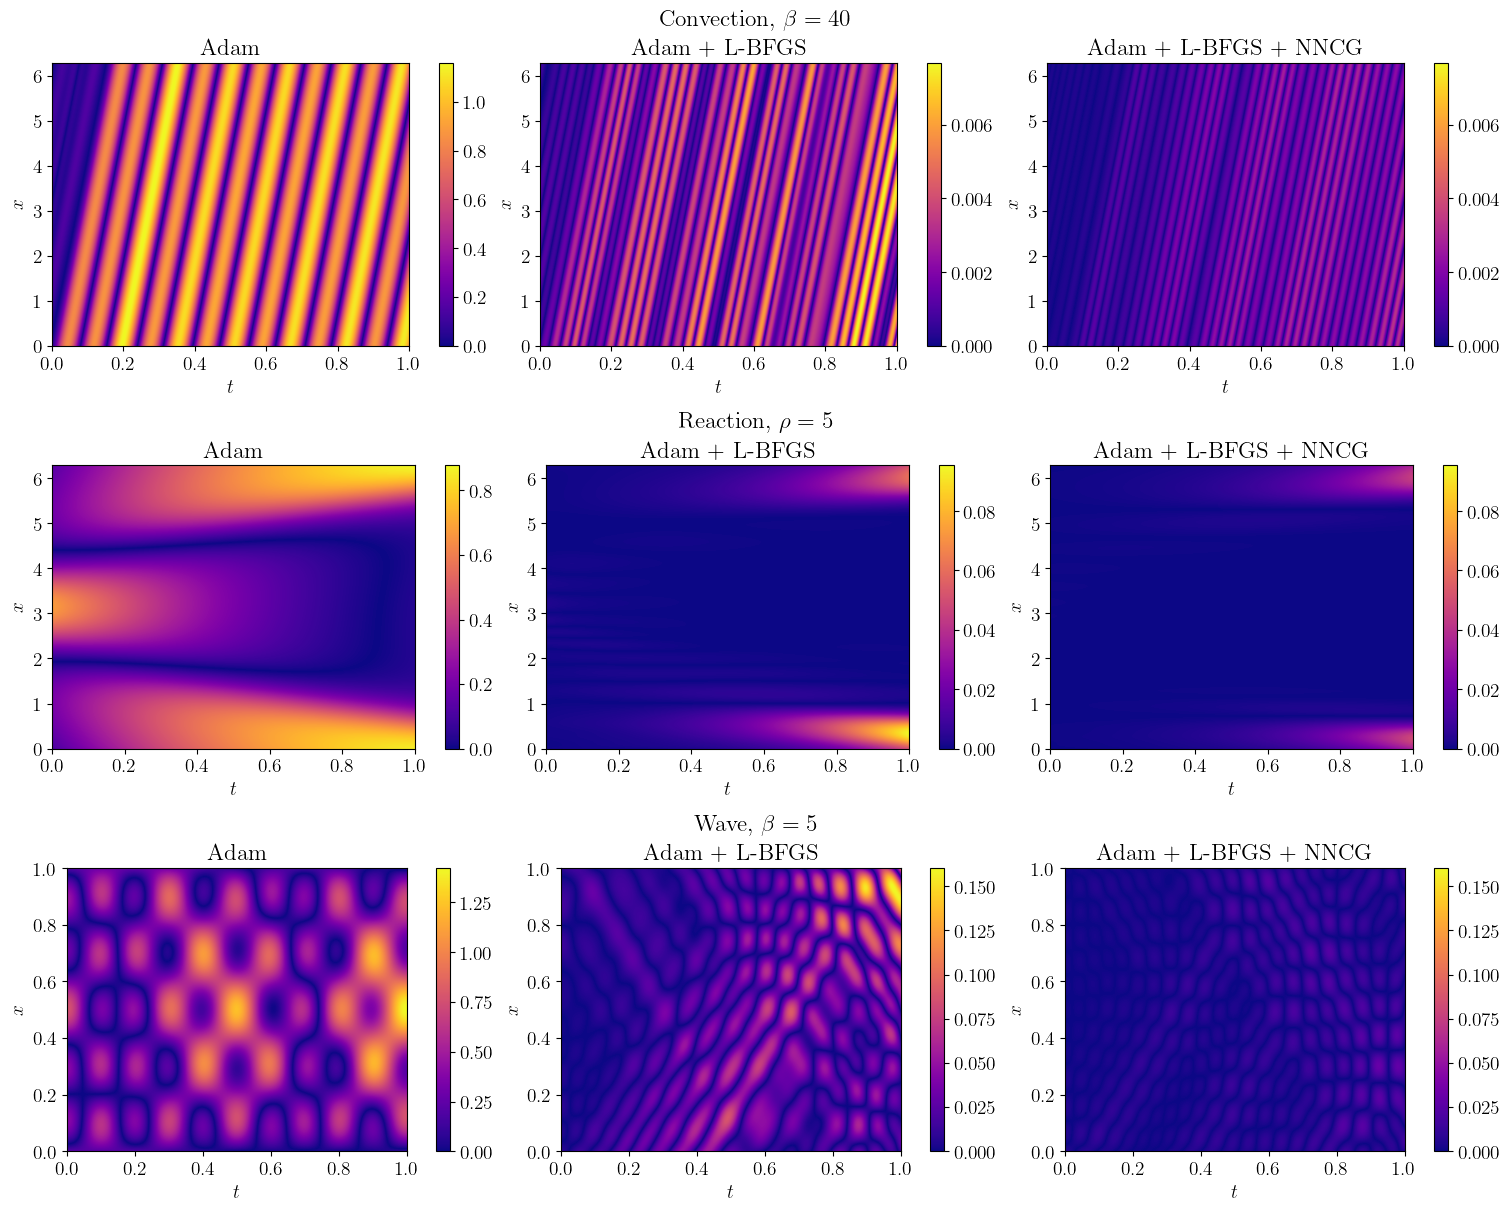

In [6]:
# make sure texts are rendered in serif via LaTex
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

font_size = 14
folder_path = 'solution'
filename = 'solution_errors' + '.pdf'
num_samples_x = 2049
num_samples_t = 1001

plot_solution_errors(run_specs[:3], num_samples_x, num_samples_t, device, font_size, folder_path, filename)

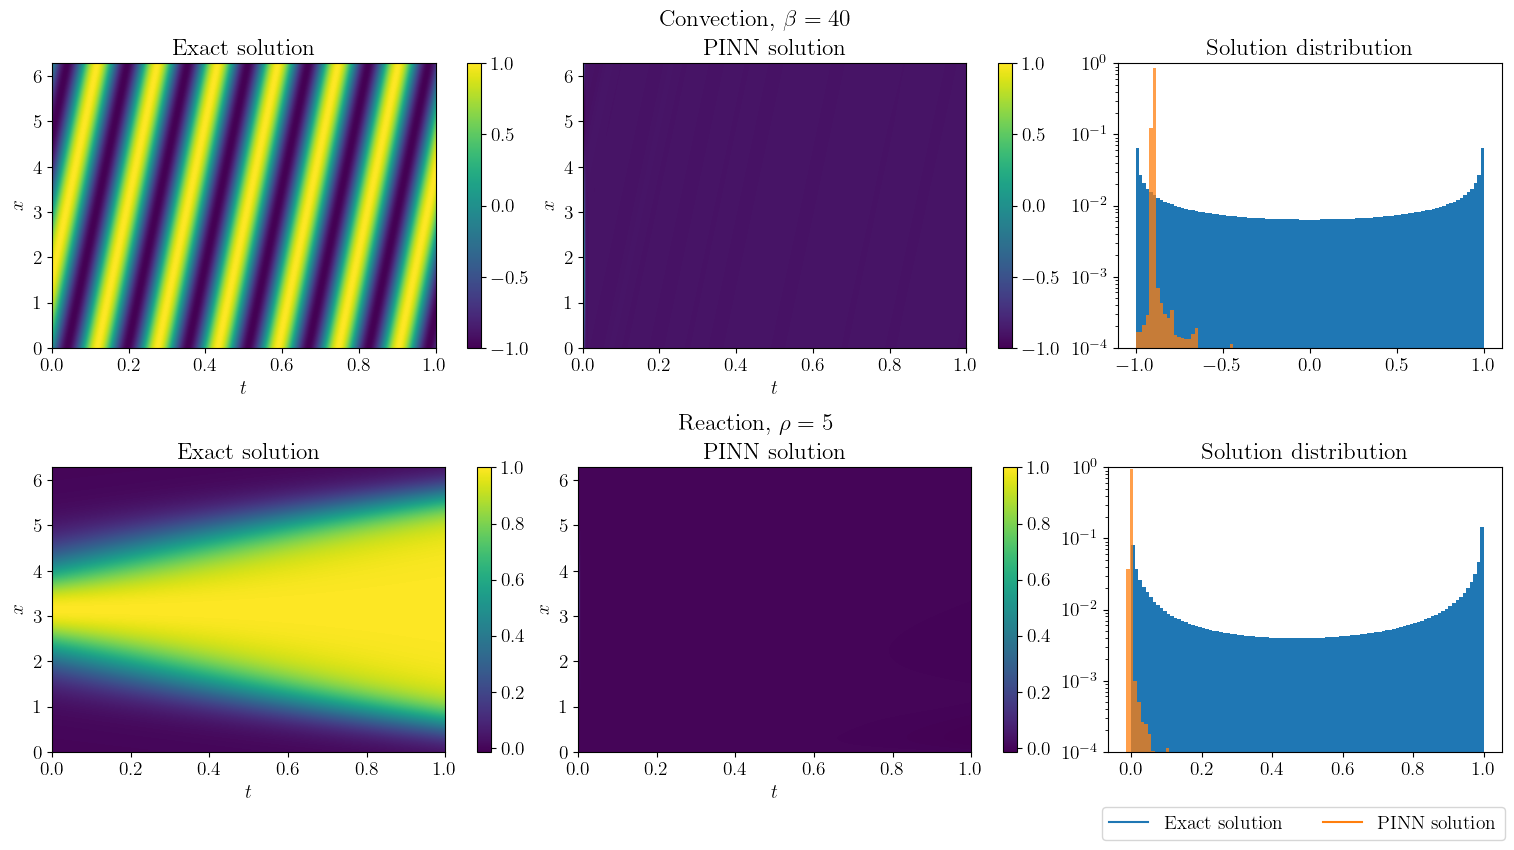

In [7]:
filename = 'high_l2re_solutions' + '.pdf'
plot_solutions(run_specs[3:], num_samples_x, num_samples_t, device, font_size, folder_path, filename)